# Logistic Regression Model

## Data Import And Cleaning

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import scripts.logistic_regression_functions as lrf
import scripts.helper_functions as hf
from functools import partial

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_files = ['../../data/cleaned/utah_2017_vineyard.csv', 
               '../../data/cleaned/utah_2017_marina.csv']

test_files = ['../../data/cleaned/utah_2018_marina.csv',
               '../../data/cleaned/utah_2018_bird.csv']

drop_columns = ['Chlorophyll ug/L', 'Chlorophyll RFU', 'Wiper Pos V',
                'Cable Pwr V', 'Battery V', 'Chlorophyll (ug/L)', 'FDOM RFU']

x_columns = ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)',
            'ODOSat%', 'ODO (mg/L)']

target_column = 'BGA-Phycocyanin RFU'

# TODO Create average off of minor bloom
RFU_THRESHOLD = 1.2
train_index = 0
test_index = 0
#the operation to be used for math operations during training.
math_operation = partial(np.square)

In [3]:
# Load the data
train_dfs = lrf.import_df_data(train_files, drop_columns)
test_dfs = lrf.import_df_data(test_files, drop_columns)

train_dfs[train_index].head()

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4


In [4]:
test_dfs[test_index].head()

,Time America/Boise UTC-06:00,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,4/11/2018 10:30,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6
1,4/11/2018 10:45,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6
2,4/11/2018 11:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7
3,4/11/2018 11:15,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7
4,4/11/2018 11:30,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7


In [5]:
train_dfs[train_index].describe()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
count,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000
mean,18.488235,1933.564575,-116.806951,8.633415,58.129348,87.056980,8.179008,0.979511
std,6.134464,151.800551,8.973830,0.147231,54.622278,13.793755,1.278416,0.731423
min,5.630000,3.000000,-153.700000,7.930000,0.660000,62.800000,5.170000,0.000000
25%,12.700000,1848.000000,-120.800000,8.530000,29.850000,80.000000,7.260000,0.500000
50%,20.320000,1939.000000,-115.700000,8.650000,42.140000,83.200000,8.080000,0.900000
75%,23.630000,2070.000000,-112.100000,8.700000,65.795000,88.900000,9.250000,1.200000
max,28.570000,2164.000000,-76.500000,9.230000,636.700000,209.700000,16.170000,16.100000


In [6]:
train_dfs[train_index][[target_column]].describe()

,BGA-Phycocyanin RFU
count,18947.000000
mean,0.979511
std,0.731423
min,0.000000
25%,0.500000
50%,0.900000
75%,1.200000
max,16.100000


In [7]:
test_dfs[test_index].describe()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
count,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000
mean,19.131184,1990.294607,-196.624329,8.922357,63.929067,90.057202,8.309566,1.459773
std,5.045367,230.743946,27.769024,0.357733,70.885989,17.627283,1.486747,1.311960
min,0.000000,0.000000,-284.000000,0.000000,-0.880000,0.000000,0.000000,-0.400000
25%,15.480000,1869.000000,-216.950000,8.730000,33.750000,79.100000,7.280000,0.600000
50%,20.190000,1958.000000,-192.000000,8.920000,48.380000,85.300000,8.010000,1.000000
75%,23.070000,2149.000000,-179.500000,9.100000,68.275000,95.300000,9.240000,1.700000
max,28.600000,2417.000000,0.000000,10.100000,1248.920000,245.500000,19.590000,21.100000


## Use Datetime Index

In [8]:
print(test_dfs[test_index].dtypes)
print(train_dfs[train_index].dtypes)

Time America/Boise UTC-06:00     object
Temp C                          float64
Sp Cond (uS/cm)                   int64
pH (mV)                         float64
pH                              float64
Turbidity (NTU)                 float64
ODOSat%                         float64
ODO (mg/L)                      float64
BGA-Phycocyanin RFU             float64
dtype: object
Date (mm.dd.yyyy)       object
Time 24hr               object
Temp C                 float64
Sp Cond (uS/cm)          int64
pH (mV)                float64
pH                     float64
Turbidity (NTU)        float64
ODOSat%                float64
ODO (mg/L)             float64
BGA-Phycocyanin RFU    float64
dtype: object


In [9]:
# We will need to engineer a datetime column for our 2017 data

# Create a single datetime column from the strings provided in our csv's
for i in range(0, len(train_dfs)):
    timestamp = train_dfs[i]['Date (mm.dd.yyyy)'] + ' '+ train_dfs[i]['Time 24hr']
    timestamp = pd.to_datetime(timestamp)
    train_dfs[i]['timestamp'] = timestamp
    train_dfs[i]['datetime'] = timestamp
    train_dfs[i] = train_dfs[i].set_index('timestamp')
    train_dfs[i] = train_dfs[i].drop(columns=['Date (mm.dd.yyyy)', 'Time 24hr'])
train_dfs[train_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00


In [10]:
# Now to datetime index our 2018 data
for i in range(0, len(test_dfs)):
    timestamp = pd.to_datetime(test_dfs[i]['Time America/Boise UTC-06:00'])
    test_dfs[i]['timestamp'] = timestamp
    test_dfs[i]['datetime'] = timestamp
    test_dfs[i] = test_dfs[i].set_index('timestamp')
    test_dfs[i] = test_dfs[i].drop(columns=['Time America/Boise UTC-06:00'])
test_dfs[test_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00


## Fill missing values


In [11]:
# Fill all missing values with the mean
for df in test_dfs + train_dfs:
    for column in df.columns:
        number_null = np.sum(df[column].isnull())
        column_length = len(df[column])
        print('{} percent null: {:.1f}%'.format(
            column, (number_null / column_length) * 100))
        if number_null > 0:
            print("Filling {} with mean: {}\n".format(column, df[column].mean()))
            df[column] = df[column].fillna(df[column].mean()) 

Temp C percent null: 0.0%
Sp Cond (uS/cm) percent null: 0.0%
pH (mV) percent null: 0.0%
pH percent null: 0.0%
Turbidity (NTU) percent null: 0.0%
ODOSat% percent null: 0.0%
ODO (mg/L) percent null: 0.0%
BGA-Phycocyanin RFU percent null: 0.0%
datetime percent null: 0.0%
Temp C percent null: 0.0%
Sp Cond (uS/cm) percent null: 0.0%
pH (mV) percent null: 0.0%
pH percent null: 0.0%
Turbidity (NTU) percent null: 0.0%
ODOSat% percent null: 0.0%
ODO (mg/L) percent null: 0.0%
BGA-Phycocyanin RFU percent null: 0.0%
datetime percent null: 0.0%
Temp C percent null: 0.0%
Sp Cond (uS/cm) percent null: 0.0%
pH (mV) percent null: 0.0%
pH percent null: 0.0%
Turbidity (NTU) percent null: 0.0%
ODOSat% percent null: 0.0%
ODO (mg/L) percent null: 0.0%
BGA-Phycocyanin RFU percent null: 0.0%
datetime percent null: 0.0%
Temp C percent null: 0.0%
Sp Cond (uS/cm) percent null: 0.0%
pH (mV) percent null: 0.0%
pH percent null: 0.0%
Turbidity (NTU) percent null: 3.2%
Filling Turbidity (NTU) with mean: 64.9625066543

## Threshold Investigation

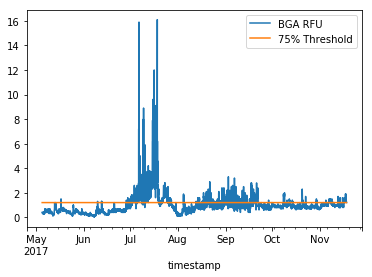

In [12]:
pd.DataFrame(
    {'BGA RFU': train_dfs[train_index][target_column], 
     '75% Threshold': np.full(train_dfs[train_index].count()[0], RFU_THRESHOLD)}).plot.line()

Mean threshold 1.1662248520710081


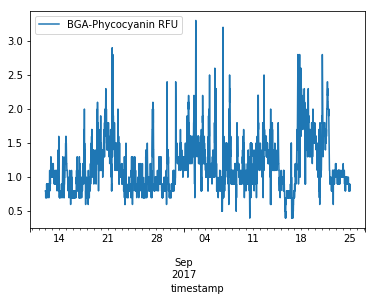

In [13]:
# Plot the smaller bloom in August through September.
start = pd.to_datetime('08/12/2017')
end = pd.to_datetime('09/25/2017')
mean_threshold = train_dfs[train_index][start:end][target_column].mean()
print("Mean threshold", mean_threshold)
train_dfs[train_index][start:end][[target_column]].plot.line()

RFU Mean 0.9795112682746124
Mean small bloom threshold 1.1662248520710081
75% threshold 1.2
95% small bloom threshold 1.9


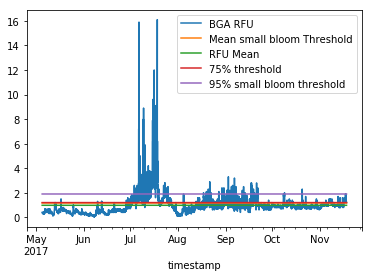

In [14]:
# Calculate average from smaller bloom in August through September.
mean_small_bloom_threshold = train_dfs[train_index][start:end][target_column].mean()
near_max_small_bloom_threshold = train_dfs[train_index][start:end][target_column].quantile(0.95)
rfu_mean = train_dfs[train_index][target_column].mean()
rfu_75 = train_dfs[train_index][target_column].quantile(0.75)
print("RFU Mean", rfu_mean)
print("Mean small bloom threshold", mean_small_bloom_threshold)
print("75% threshold", rfu_75)
print("95% small bloom threshold", near_max_small_bloom_threshold)
pd.DataFrame(
    {'BGA RFU': train_dfs[train_index][target_column], 
     'Mean small bloom Threshold': 
     np.full(train_dfs[train_index].count()[0], mean_threshold),
    'RFU Mean':rfu_mean,
    '75% threshold':rfu_75,
    '95% small bloom threshold': near_max_small_bloom_threshold}).plot.line()

## Create Targets Based on Date Range

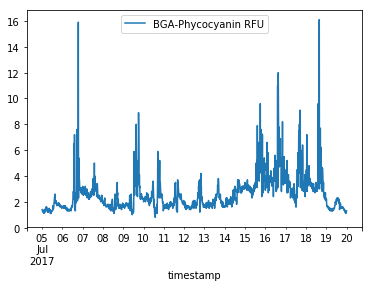

In [15]:
small_start_train = start
small_end_train = end
big_start_train = pd.to_datetime('07/05/2017')
big_end_train = pd.to_datetime('07/20/2017')
train_dfs[train_index][big_start_train:big_end_train][[target_column]].plot.line()

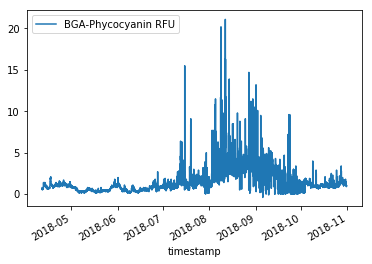

In [16]:
test_dfs[test_index][[target_column]].plot.line()

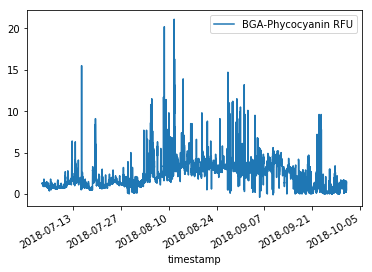

In [17]:
start_test = pd.to_datetime('07/04/2018')
end_test = pd.to_datetime('10/01/2018')
test_dfs[test_index][start_test:end_test][[target_column]].plot.line()

## Extract Windows


In [18]:
presegmented_plot = pd.DataFrame(
    {'BGA RFU': train_dfs[train_index][target_column], 
     'Bloom Threshold': np.full(train_dfs[train_index].count()[0], RFU_THRESHOLD)})
print("Pre-segmented length:", len(train_dfs[train_index][target_column]))
# Segment each data frame
for i in range(0, len(train_dfs)):
    print("Windowizing 2017 data set:", i)
    train_dfs[i] = hf.data_window_reduction(
        train_dfs[i], 'datetime', target_column)
    print("Windowizing 2018 data set:", i)
    test_dfs[i] = hf.data_window_reduction(
        test_dfs[i], 'datetime', target_column)
    print()
print("Post Segmented Length:", len(train_dfs[train_index][target_column]))

Pre-segmented length: 18947
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Windowizing 2017 data set: 1
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 1
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Post Segmented Length: 331


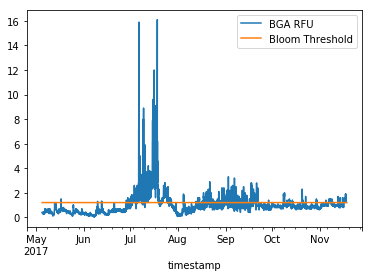

In [19]:
presegmented_plot.plot.line()

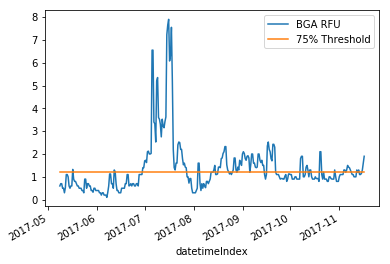

In [20]:
pd.DataFrame(
    {'BGA RFU': train_dfs[train_index][target_column], 
     '75% Threshold': np.full(train_dfs[train_index].count()[0], RFU_THRESHOLD)}).plot.line()

## Logistic Regression Model


## Threshold Loop

In [21]:
max_iter = 25000
loss = "log"
base_columns = ['ODOSat%', 'ODO (mg/L)', 'pH', 'Temp C', 'Sp Cond (uS/cm)']
thresholds = [round(0.9 + (x/10), 1) for x in range(1, 12)]
thresholds.append(rfu_mean)
thresholds.append(mean_small_bloom_threshold)
thresholds = sorted(thresholds)
accuracies = []
for threshold in thresholds:
    train = train_dfs[train_index].copy()
    test = test_dfs[test_index].copy()
    lrf.add_target_column([train, test], threshold=threshold)
    print("Training model with threshold:", threshold)
    model = SGDClassifier(max_iter=max_iter, loss=loss)
    accuracy, recall, precision, cm, _, _, _ = lrf.train_model(
        model, train, test, base_columns, 'bloom')
    accuracies.append(accuracy)
    print("Accuracy", accuracy)
    print("Recall:", recall)
    print("Precision", precision)
    print("Confusion Matrix:\n", cm)
    print("columns:", base_columns)
    


Training model with threshold: 0.9795112682746124
Accuracy 0.8357771260997068
Recall: 0.94921875
Precision 0.8496503496503497
Confusion Matrix:
 [[ 42  43]
 [ 13 243]]
columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'Temp C', 'Sp Cond (uS/cm)']
Training model with threshold: 1.0
Accuracy 0.8035190615835777
Recall: 0.9449152542372882
Precision 0.8050541516245487
Confusion Matrix:
 [[ 51  54]
 [ 13 223]]
columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'Temp C', 'Sp Cond (uS/cm)']
Training model with threshold: 1.1
Accuracy 0.7741935483870968
Recall: 0.8973214285714286
Precision 0.788235294117647
Confusion Matrix:
 [[ 63  54]
 [ 23 201]]
columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'Temp C', 'Sp Cond (uS/cm)']
Training model with threshold: 1.1662248520710081
Accuracy 0.7947214076246334
Recall: 0.8783783783783784
Precision 0.819327731092437
Confusion Matrix:
 [[ 76  43]
 [ 27 195]]
columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'Temp C', 'Sp Cond (uS/cm)']
Training model with threshold: 1.2
Accuracy 0.8240469208

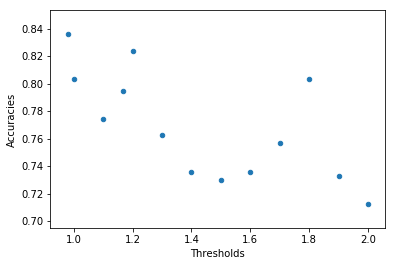

In [22]:
pd.DataFrame(
    {"Thresholds": thresholds, "Accuracies": accuracies}
).plot.scatter(x='Thresholds', y='Accuracies')

In [23]:
# Testing round functionality
round(1.11000008, 1)

1.1

In [24]:
# Testing threshold list
[round(0.9 + (x/10), 1) for x in range(1, 12)]

[1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]

## Test Targets Based On Date Range

In [25]:
train = train_dfs[train_index].copy()
test = test_dfs[test_index].copy()

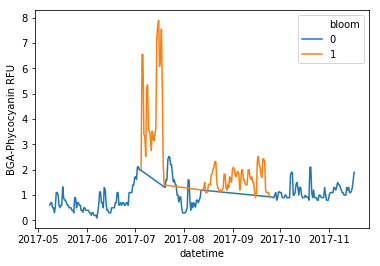

In [26]:
train['bloom'] = train['datetime'].apply(lambda d: 1 
            if ((d >= small_start_train 
                 and d <= small_end_train) 
           or (d >= big_start_train 
               and d <= big_end_train))
           else 0)
sns.lineplot(data=train, x='datetime', y=target_column, hue='bloom')

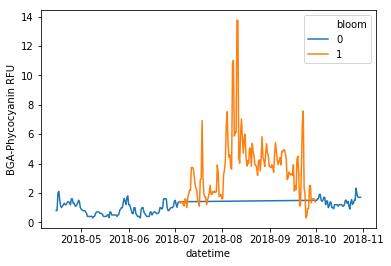

In [27]:
test['bloom'] = test['datetime'].apply(lambda d: 1 
            if (d >= start_test 
                 and d <= end_test)
           else 0)
sns.lineplot(data=test, x='datetime', y=target_column, hue='bloom')

In [ ]:

model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, _, _, _ = lrf.train_model(
    model, train, test, base_columns, 'bloom')
accuracies.append(accuracy)
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)
print("columns:", base_columns)